## Import relevant packages ##

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import emcee
from astropy.io import ascii
import corner
import os
from timeit import default_timer as timer
import matplotlib.colors as colors
import matplotlib.cm as cmx
import matplotlib.lines as mlines
from scipy.optimize import least_squares, curve_fit
from scipy.stats import f
from astropy.table import Table, vstack
import pandas as pd
import lmfit
from matplotlib import rcParams
from matplotlib.colors import LinearSegmentedColormap

In [3]:
# define colors to be used across presentation:
lime = '#e4ffba'
lemon = '#fef6c7'
bora = '#b186ce'
sky = '#b2eaf0'
strawberry = '#ff9cff'
coral = '#feb5a4'

In [4]:
# Set Matplotlib style parameters for dark background
rcParams['figure.facecolor'] = 'black'  # Dark background color
rcParams['axes.facecolor'] = 'black'
rcParams['axes.edgecolor'] = sky
rcParams['axes.labelcolor'] = sky
rcParams['xtick.color'] = sky
rcParams['ytick.color'] = sky
rcParams['text.color'] = sky
rcParams['axes.titlecolor'] = sky

## Define plotting functions:

In [5]:
def plot_data(ax, sm, data, mode, scaled=False, **kwargs):
    telescope_marker_dict = {'VLA':('s', lime), 'ALMA':('o', bora), 'e-MERLIN':('d', coral)}

    for row in data:
        if mode == 'lc':
            x = row['time']
            # set marker color based on frequency
            freq = row['freq']
            colorval = sm.to_rgba(freq)
        if mode == 'sed':
            x = row['freq']
            # set marker color based on time
            time = row['time']
            # colorval = sm.to_rgba(time)

        telescope = row['telescope']
        marker = telescope_marker_dict[telescope][0]
        color = telescope_marker_dict[telescope][1]
        
        if scaled:
            flux = row['scaled_flux']
            err = row['scaled_flux_err']
        else:
            flux = row['flux']
            err = row['flux_err']

        ax.errorbar(x, flux, yerr=err, marker=marker, c=sky)
    return

def make_plot(data, mode, title='', xlabel='', ylabel='', freq_vals=np.linspace(0, 300, 300), cbar=True, scaled=False, models=None, params=None, model_names=None, plot_models=False, modelcolors=None, vline=None, vlinecolors=None, ylim=None):
    fig = plt.figure(figsize=(8,6))
    ax = fig.add_subplot(111)

    if cbar:
        # get the scalar map, plot the data using the plot_data function
        sm = cmap_setup(mode)
        plot_data(ax, sm, data, mode, scaled=scaled)

        # set up colorbar
        if mode == 'lc':
            fig.colorbar(sm, fraction=0.046, label=r'$\nu$ [GHz]')
        elif mode == 'sed':
            fig.colorbar(sm, fraction=0.046, label='time [Days]')
    else:
        sm = None
        plot_data(ax, sm, data, mode, scaled=scaled)

    # set axis scales to log
    ax.set_yscale('log')
    ax.set_xscale('log')

    #Label axes, set axis limits etc.
    ax.set_xlabel(xlabel)
    ax.set_title(title)
    if scaled:
        ax.set_ylabel('Scaled Flux Density (mJy)')
        ax.set_title('Scaled to 3 GHz')
    else:
        ax.set_ylabel(ylabel)

    if mode == 'lc':
        x = data['time']
    elif mode == 'sed':
        x = data['freq']

    if models!=None:
        for i, (model,param,model_name,color) in enumerate(zip(models,params,model_names,modelcolors)):
            plot_model(model, param, x, ax, model_name, color, freq_vals=freq_vals, ylim=ylim)

    if vline != None:
        for i, (line, linecolor) in enumerate(zip(vline, vlinecolors)):
            ax.axvline(x=line, color=linecolor, linestyle='--')

cmap = LinearSegmentedColormap.from_list('custom_cmap', [coral, bora], N=256)
def cmap_setup(mode, cmap=cmap, min_freq=0, max_freq=300, min_time=1360, max_time=1370):
    '''
    color markers by frequency/time
    '''
    if mode == 'lc':
        freq_cmap = plt.cm.get_cmap(cmap)
        
        cNorm  = colors.Normalize(vmin=min_freq, vmax=max_freq)
        scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=cmap)
        sm = scalarMap
        sm._A = []
    elif mode == 'sed':
        time_cmap = plt.cm.get_cmap(cmap)
        
        cNorm  = colors.Normalize(vmin=min_time, vmax=max_time)
        scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=cmap)
        sm = scalarMap
        sm._A = []
    
    return sm   


# define model plotting function to be incorporated into makeplot()
def plot_model(model, params, x, ax, label, modelcolor, freq_vals=np.linspace(0, 300, 300), ylim=None):

    sorted_indices = np.argsort(x)
    x_sorted = x[sorted_indices]

    fit = model(freq_vals, *params)
    ax.plot(freq_vals, fit, label=label, color=modelcolor)
    if ylim != None:
        ax.set_ylim(ylim)
    ax.legend()
    return

## Input Flux Density Values

From my project:

In [6]:
# create another data table with the data from my project:
# observation type:
# 6211, 6355, 6488, 5859, 6035, 7037, 6759, 7214
observation = np.array(['KuD', 'XD', 'CD', 'KD', 'KaD', 'KA', 'XA', 'KaA'])

# days since explosion
phase = np.array([1363.2, 1365.1, 1368.1, 1369.2, 1369.1, 1688.1, 1689.9, 1702.2])

# frequency of each observation (GHz)
freq = np.array([15.1, 10.0, 6.0, 22.0, 33.0, 22.0, 10.0, 33.0])

# fluxes at each time/frequency (mJy)
# 0 just means I have yet to input that value
flux = np.array([6.476, 7.023, 7.0, 7.055, 2.7, 3.485, 5.882, 3.072])

# 1 sigma flux errors at each time/frequency (mJy)
flux_err = np.array([0.818, 0.944, 0.5, 0.673, 0.2, 0.468, 0.577, 0.177])

# telescope observation was made with
telescope = np.array(['VLA']*8)

table = np.column_stack((observation, phase, freq, flux, flux_err, telescope))
data = Table(table, names=['observation', 'time', 'freq', 'flux', 'flux_err', 'telescope'])
data['time'] = data['time'].astype(float)
data['freq'] = data['freq'].astype(float)
data['flux'] = data['flux'].astype(float)
data['flux_err'] = data['flux_err'].astype(float)

From previous ALMA data:

In [7]:
# observation, just to match the other table:
observation = np.zeros(16)

# days since explosion
phase = np.array([4.1, 7.1, 17.1, 21.0, 198.6, 213.5, 306.2, 1024.4, 1364.4, 4.1, 6.2, 17.1, 198.6, 1364.4, 1217, 1217])

# frequency of each observation (GHz)
freq = np.array([100.0, 100.0, 100.0, 93.5, 100.0, 92.1, 103.0, 92.1, 100.0, 250.0, 250.0, 250.0, 250.0, 250.0, 6.5, 6.3])

# fluxes at each time/frequency (mJy)
flux = np.array([4.25, 7.42, 9.05, 7.41, 0.336, 0.322, 0.264, 1.128, 0.955, 4.21, 4.32, 2.49, 0.120, 0.286, 9.1, 8.7])

# 1 sigma flux errors at each time/frequency (mJy)
flux_err = np.array([0.22, 0.38, 0.46, 0.99, 0.026, 0.036, 0.044, 0.069, 0.093, 0.43, 0.44, 0.28, 0.022, 0.067, 0.9, 1.3])

# telescope observation was made with
alma = np.array(['ALMA']*14)
vla = np.array(['VLA'])
emerlin = np.array(['e-MERLIN'])
telescope = np.concatenate((alma, vla, emerlin))

table = np.column_stack((observation, phase, freq, flux, flux_err, telescope))
data_ALMA = Table(table, names=['observation','time', 'freq', 'flux', 'flux_err', 'telescope'])
data_ALMA['time'] = data_ALMA['time'].astype(float)
data_ALMA['freq'] = data_ALMA['freq'].astype(float)
data_ALMA['flux'] = data_ALMA['flux'].astype(float)
data_ALMA['flux_err'] = data_ALMA['flux_err'].astype(float)

In [8]:
# concatenate the two tables:
all_data = vstack([data, data_ALMA])
all_data

observation,time,freq,flux,flux_err,telescope
str32,float64,float64,float64,float64,str32
KuD,1363.2,15.1,6.476,0.818,VLA
XD,1365.1,10.0,7.023,0.944,VLA
CD,1368.1,6.0,7.0,0.5,VLA
KD,1369.2,22.0,7.055,0.673,VLA
KaD,1369.1,33.0,2.7,0.2,VLA
KA,1688.1,22.0,3.485,0.468,VLA
XA,1689.9,10.0,5.882,0.577,VLA
KaA,1702.2,33.0,3.072,0.177,VLA
0.0,4.1,100.0,4.25,0.22,ALMA


## Define the relations that will be used for fitting:

FFA dominant case:
$$\tau_{\nu}^{\text{FFA}} = K_2\nu^{-2.1}$$
$$F_{\nu} = K_1\nu^{-\alpha}(e^{-\tau_{\nu}^{\text{FFA}}})$$

In [9]:
def F_FFA(freq, K1, K2, alpha):
    """
    Calculate the flux density using Synchotron Self Absorption (SSA) model.

    Parameters:
    freq (float or numpy.ndarray): Frequency values.
    K1 (float): Scaling factor.
    K2 (float): Scaling factor for the optical depth.
    p (float): Power-law index.

    Returns:
    F (numpy.ndarray): Flux density values.
    """
    #scale the freqs by 10
    tau = K2 * (freq/10)**(-2.1)
    F = K1 * (freq/10)**(-alpha) * (np.exp(-tau))
    return F

## Fitting to the FFA model

Find the best fit to the data using curve_fit. These will be used as the priors for the MCMC analysis.

In [10]:
def calc_params(data, model, initial_guess):
    # define variables from data
    freq = data['freq']
    flux = data['flux']
    flux_err = data['flux_err']

    params, covariance = curve_fit(model, freq, flux, p0=initial_guess, bounds=((0,0,0),(np.inf, np.inf,4.0)), sigma=flux_err, absolute_sigma=True)

    K1_fit, K2_fit, alpha_fit = params
    K1_err, K2_err, alpha_err = np.sqrt(np.diag(covariance))

    # Create a dictionary to store the results
    results = {
        'K1': (K1_fit, K1_err),
        'K2': (K2_fit, K2_err),
        'alpha': (alpha_fit, alpha_err)
    }

    return results

In [11]:
# take the subset of the data at ~1360 days:
data_1 = all_data[((all_data['time'] < 1370.0) & (all_data['time'] > 1360.0) & (all_data['observation'] != 'CD'))]
results = calc_params(data_1, F_FFA, [100, 0.1, 1.5])
results

{'K1': (13.260882363896496, 1.9807874866992259),
 'K2': (0.5896096795157248, 0.2192409602572109),
 'alpha': (1.179185591994737, 0.08558188856035708)}

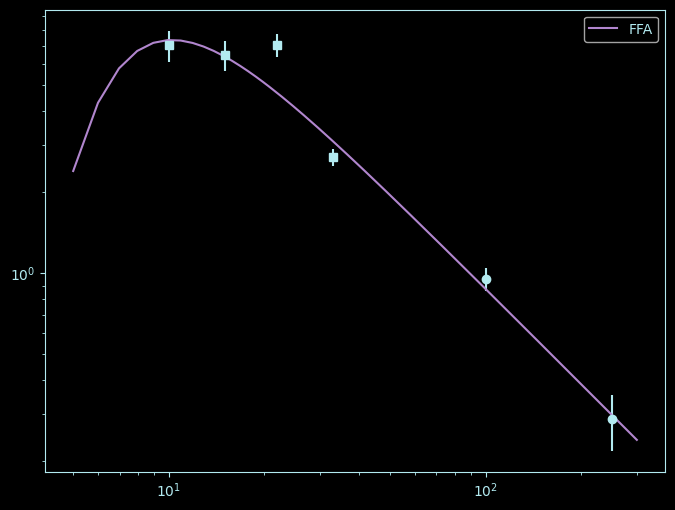

In [12]:
K1 = results['K1'][0]
K2 = results['K2'][0]
p = results['alpha'][0]
make_plot(data_1, 'sed', freq_vals=np.linspace(5, 300, 300), models=[F_FFA], params=[[K1, K2, p]], model_names = ['FFA'], cbar=False, modelcolors=[bora])

Define a prior that imposes the following conditions on our fit. We will input the paramters into the prior as a tuple.
- $K_1 = 13.26 \pm 1.98$
- $K_2 = 0.59 \pm 0.22$
- $p = 1.18 \pm 0.09$

In [13]:
# uniform prior:
def lnprior(theta):
    K1, K2, p = theta
    return 0.0

We will now write a likelihood function that takes the SED parameters inside the tuple theta, along with the observed data.

In [14]:
# F is the flux densities from the data
# F_err are the rms values from the data
def lnlike(theta, nu, F, F_err):
    K1, K2, alpha = theta

    model = F_FFA(nu, K1, K2, alpha)
    inv_sigma2 = 1.0/F_err**2

    return -0.5*(np.sum((F-model)**2*inv_sigma2 - np.log(inv_sigma2)))

Now write a function to calculate the marginal probability using the lnlike() and lnprior() functions you calculated above

In [15]:
def lnprob(theta, nu, F, F_err):
    lp = lnprior(theta)

    if not np.isfinite(lp):
        return -np.inf

    return lp + lnlike(theta, nu, F, F_err)

Get starting positions of walkers for each parameter

In [16]:
K1 = results['K1'][0]
K2 = results['K2'][0]
alpha = results['alpha'][0]

def get_starting_pos(nwalkers, ndim=3):
    
    pos = [np.asarray([K1, K2, alpha]) + 1e-4*np.random.randn(ndim) for i in range(nwalkers)]
    
    return pos

Write a function to load the data, take the starting positions, and run the mcmc ensemble sampler:

In [17]:
def run_mcmc(data, niters=1000, nthreads=1, nwalkers=200, ndim=3):
    nu = data['freq']
    F = data['flux']
    F_err = data['flux_err']
    
    pos = get_starting_pos(nwalkers, ndim=ndim)
    
    sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=(nu, F, F_err),threads=nthreads)
    
    start = timer()
    sampler.run_mcmc(pos, niters)
    end = timer()
    
    print("Computation time: %f s"%(end-start))
    
    return sampler


Actually save the sampler and the chain, to inspect how long the burn-in phase lasts:

In [18]:
sampler = run_mcmc(data_1, niters=2000, nwalkers=400)
chain = sampler.chain

Computation time: 116.522267 s


Assess where the burn in phase occurs:

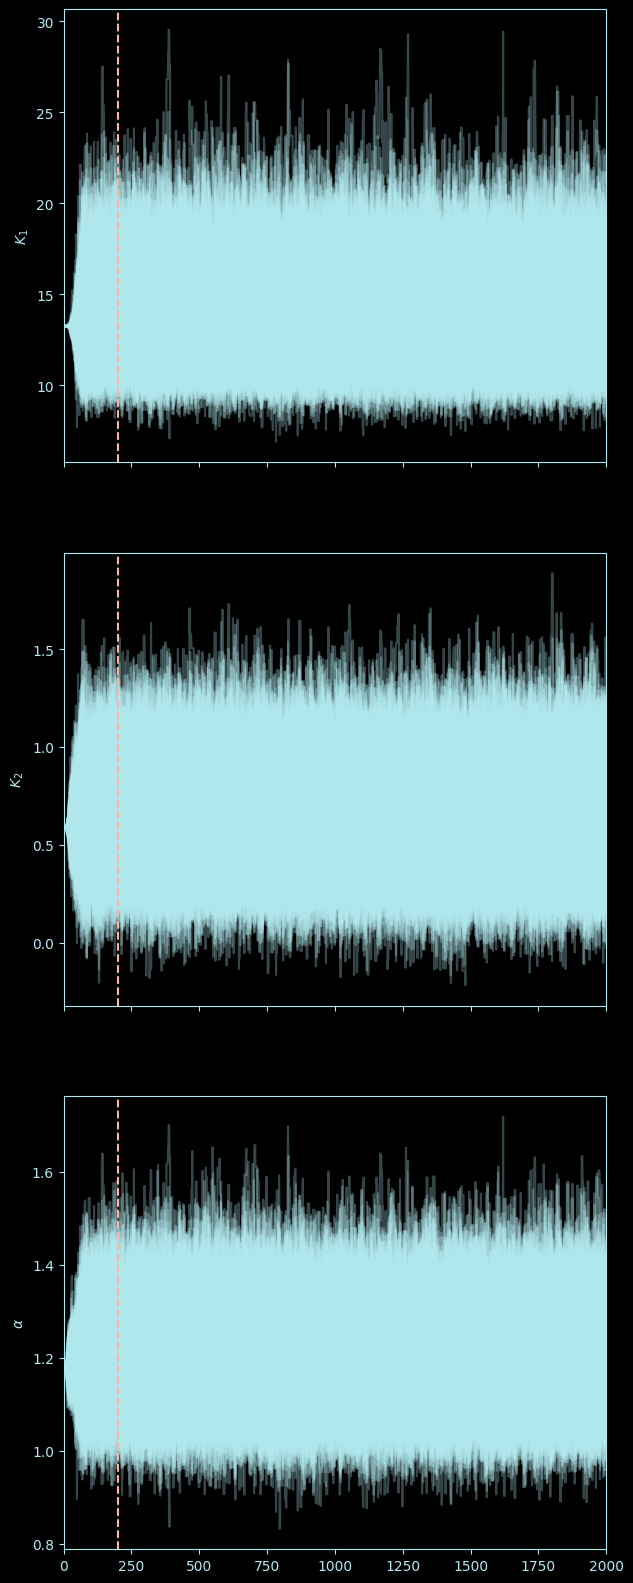

In [19]:
def make_chain_plot(chain, chain_cut):
    niters = chain.shape[1]
    ndim = chain.shape[2]

    fig, axes = plt.subplots(ndim,1,sharex=True)
    fig.set_size_inches(7, 20)
    
    param_names = ['$K_1$', '$K_2$',r'$\alpha$']

    for i, (ax,param_name) in enumerate(zip(axes,param_names)):
        #plot the chain for the given parameter
        ax.plot(chain[:,:,i].T, linestyle='-', color=sky, alpha=0.3)
        
        
        ax.set_ylabel(param_name)
        ax.set_xlim(0,niters)
        
        
        ax.axvline(chain_cut,c=coral,linestyle='--')

chain_cut = 200

make_chain_plot(chain, chain_cut)

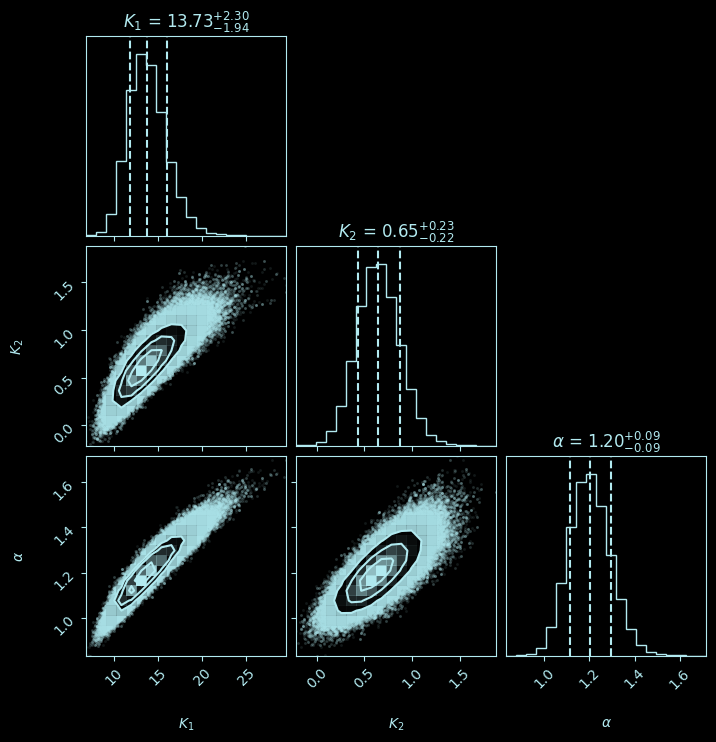

In [20]:
def make_corner_plot(good_chain, savefile='corner.png'):
    param_names = ['$K_1$', '$K_2$',r'$\alpha$']
    ndim = good_chain.shape[2]

    # Create the corner plot
    fig = corner.corner(good_chain.reshape((-1, ndim)), labels=param_names, quantiles=[0.16, 0.5, 0.84], show_titles=True, facecolor='black')
    
    # Save the plot
    #plt.savefig(savefile, dpi=300, bbox_inches='tight', facecolor=fig.get_facecolor())

good_chain = chain[:, chain_cut:, :]
make_corner_plot(good_chain)

The function below will then extract the median and uncertainty (1 standard deviation) from the chain.

In [21]:
def get_best_params(chain):
    ndim = chain.shape[2] # 3 in this case
    
    chain = chain.reshape((-1, ndim))
    vals = map(lambda v: (v[1], v[2]-v[1], v[1]-v[0]), zip(*np.percentile(chain, [16, 50, 84],axis=0)))
    # ^^ takes every value in the zip() and returns v[1] (actual value), v[2]-v[1] (median?), v[1]-v[0] (1 sigma uncertainty?)

    param_names = ['$K_1$', '$K_2$',r'$\alpha$']
    
    param_dict = dict(zip(param_names,vals))
    
    return param_dict
 
best_params = get_best_params(good_chain)
best_params

{'$K_1$': (13.732310520832257, 2.2977851713235005, 1.9424901793766125),
 '$K_2$': (0.6461966810379487, 0.22914524085352306, 0.21579562335016766),
 '$\\alpha$': (1.2005158978872834, 0.09348064613386264, 0.08607297077559495)}

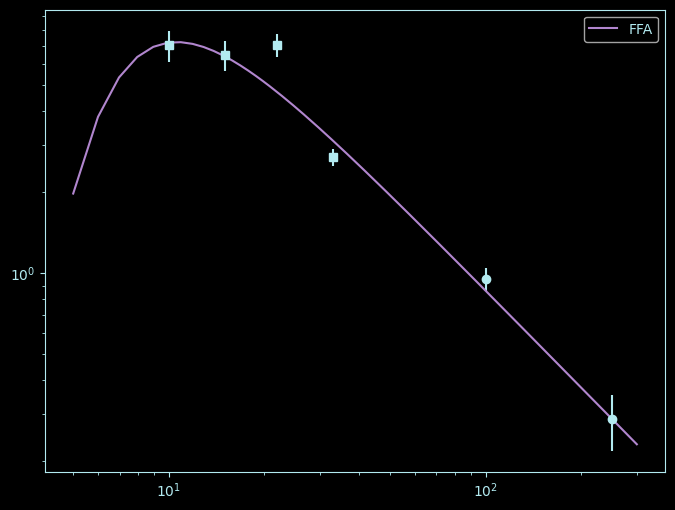

In [31]:
K1 = best_params['$K_1$'][0]
K2 = best_params['$K_2$'][0]
alpha = best_params[r'$\alpha$'][0]
make_plot(data_1, 'sed', freq_vals=np.linspace(5, 300, 300), models=[F_FFA], params=[[K1, K2, alpha]], model_names = ['FFA'], cbar=False, modelcolors=[bora])

Determine the peak flux density and the frequency it occurs for the ~1360 day epoch:

In [32]:
# define a function that just returns tau:
def tau_FFA(freq, K2):
    #scale the freqs by 10
    tau = K2 * (freq/10.0)**(-2.1)
    return tau

# get tau values by frequency:
K2 = best_params['$K_2$'][0]
freq_vals = np.linspace(5, 300, 300)
flux_vals = F_FFA(freq_vals, K1, K2, alpha)
tau_early = tau_FFA(freq_vals, K2)

# combine frequencies and taus into an astropy table:
table = np.column_stack((freq_vals, tau_early))
tau_by_freq = Table(table, names=['freq', 'tau'])

# combine frequencies and fluxes into an astropy table:
table = np.column_stack((freq_vals, flux_vals))
flux_by_freq = Table(table, names=['freq', 'flux'])

# choose tau at 10 GHz, our scaling factor:
tau_10GHz = tau_FFA(10, K2)
tau_10GHz

# write the loop to determine the max
max = flux_by_freq['flux'][0]
max_freq = flux_by_freq['freq'][0]

for i in range(len(flux_by_freq)):
    if flux_by_freq['flux'][i] > max:
        max = flux_by_freq['flux'][i]
        max_freq = flux_by_freq['freq'][i]

print(max)
print(max_freq)

7.22063446083139
10.919732441471572


Now write a function, calc_chi2(), that will calculate the $\chi^2$ for the fit. We will use this later to compare different lightcurve models

In [24]:
def calc_chi2(best_params, param_names, model, data):
    args = []
    for param in param_names:
        val = best_params[param][0]
        args.append(val)

    best_fit = model(data['freq'], *args)
    
    chi2 = np.sum((best_fit-data['flux'])**2/data['flux_err']**2)
    
    return chi2

param_names = ['$K_1$', '$K_2$',r'$\alpha$']

chi2_best = calc_chi2(best_params, param_names, F_FFA, data_1)
print(chi2_best)

17.353702573140342


In [25]:
# calculate reduced chi2:
npts = 6
nparams = 3
dof = npts-nparams
reduced_chi2 = chi2_best/dof
reduced_chi2

5.7845675243801145

For the ~1700 day epoch, I will use lmfit in order to be able to hold the $\alpha$ value constant

In [26]:
Aconfig_data = data[data['time'] >= 1600.0]
Aconfig_data

observation,time,freq,flux,flux_err,telescope
str32,float64,float64,float64,float64,str32
KA,1688.1,22.0,3.485,0.468,VLA
XA,1689.9,10.0,5.882,0.577,VLA
KaA,1702.2,33.0,3.072,0.177,VLA


In [27]:
def F_FFA(freq, K1, K2, alpha):
    """
    Calculate the flux density using Synchotron Self Absorption (SSA) model.

    Parameters:
    freq (float or numpy.ndarray): Frequency values.
    K1 (float): Scaling factor.
    K2 (float): Scaling factor for the optical depth.
    alpha (float): Power-law index.

    Returns:
    F (numpy.ndarray): Flux density values.
    """
    #scale the freqs by 10
    tau = K2 * (freq/10.0)**(-2.1)
    F = K1 * (freq/10.0)**(-alpha) * (np.exp(-tau))
    return F


# create the model object
model = lmfit.Model(F_FFA)

# apply the previously created parameters dictionary to this specific model
params = model.make_params(K1=dict(value=24.15, min=0, max=np.inf, vary=True), 
                           K2=dict(value=1.0, min=0, max = np.inf, vary=True),
                           alpha=dict(value=alpha, vary=False))

# perform the least squares minimization
leastsqs = model.fit(Aconfig_data['flux'], params, freq=Aconfig_data['freq'])

# inspect the fit
print(leastsqs.fit_report())

[[Model]]
    Model(F_FFA)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 16
    # data points      = 3
    # variables        = 2
    chi-square         = 0.41497082
    reduced chi-square = 0.41497082
    Akaike info crit   = -1.93447809
    Bayesian info crit = -3.73725351
    R-squared          = 0.90986914
[[Variables]]
    K1:     11.3131928 +/- 1.87545296 (16.58%) (init = 24.15)
    K2:     0.65926038 +/- 0.20976104 (31.82%) (init = 1)
    alpha:  1.200516 (fixed)
[[Correlations]] (unreported correlations are < 0.100)
    C(K1, K2) = +0.8539


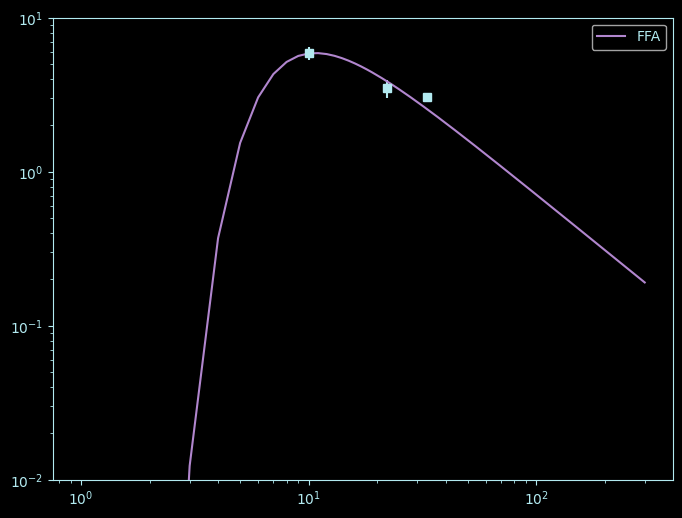

In [33]:
K1_late = 11.33
K2_late = 0.66
make_plot(Aconfig_data, 'sed', freq_vals=np.linspace(1, 300, 300), models=[F_FFA], params=[[K1_late, K2_late, alpha]], model_names = ['FFA'], cbar=False, modelcolors=[bora], ylim=(10**-2, 10**1))

Determine peak flux and frequency:

In [34]:
freq_vals = np.linspace(5, 300, 300)
flux_vals = F_FFA(freq_vals, K1_late, K2_late, alpha)

# combine frequencies and fluxes into an astropy table:
table = np.column_stack((freq_vals, flux_vals))
flux_by_freq = Table(table, names=['freq', 'flux'])

# write the loop to determine the max
max = flux_by_freq['flux'][0]
max_freq = flux_by_freq['freq'][0]

for i in range(len(flux_by_freq)):
    if flux_by_freq['flux'][i] > max:
        max = flux_by_freq['flux'][i]
        max_freq = flux_by_freq['freq'][i]

print(max)
print(max_freq)

5.889498153043599
10.919732441471572


In [29]:
data_bothepochs = all_data[((all_data['time'] > 1360.0) & (all_data['observation'] != 'KaD'))]
data_bothepochs

observation,time,freq,flux,flux_err,telescope
str32,float64,float64,float64,float64,str32
KuD,1363.2,15.1,6.476,0.818,VLA
XD,1365.1,10.0,7.023,0.944,VLA
CD,1368.1,6.0,7.0,0.5,VLA
KD,1369.2,22.0,7.055,0.673,VLA
KA,1688.1,22.0,3.485,0.468,VLA
XA,1689.9,10.0,5.882,0.577,VLA
KaA,1702.2,33.0,3.072,0.177,VLA
0.0,1364.4,100.0,0.955,0.093,ALMA
0.0,1364.4,250.0,0.286,0.067,ALMA


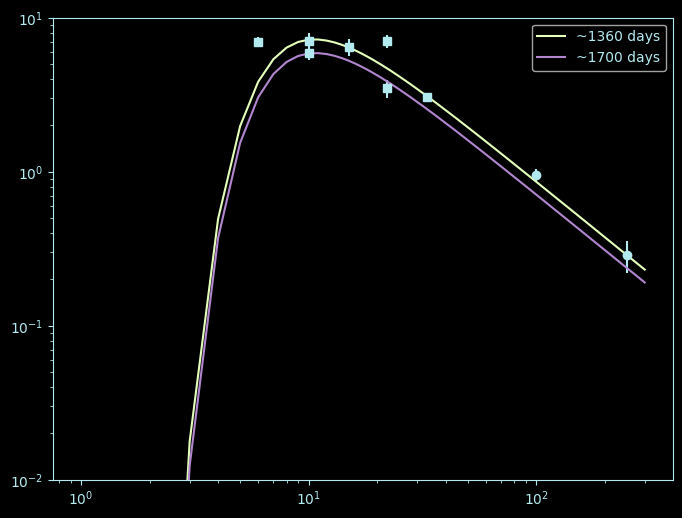

In [30]:
make_plot(data_bothepochs, 'sed', freq_vals=np.linspace(1, 300, 300), models=[F_FFA, F_FFA], params=[[K1, K2, alpha], [K1_late, K2_late, alpha]], model_names = ['~1360 days', '~1700 days'], cbar=False, modelcolors=[lime, bora], ylim=(10**-2, 10**1))